# Debris Detection [Object Detection]

Reference: https://github.com/tensorflow/models/tree/master/research/object_detection

Problem Statement: You’re encountering a large belt of space debris! You must use the tools of object detection to box this debris so you can safely take your rover to Mars.

## Table of Content
1. Download the data
2. Convert Annotations into Json format from dataframe
3. Git Clone the Tensorflow object-detection module & Setup the requirements [Tensorflow](https://github.com/tensorflow/models.git)
4. Preparation of data for the model [TF records](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/preparing_inputs.md)
5. Download Pretrained Model from [Tensorflow Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md)
6. Configure the Pipeline for training & evaluation
7. Train the model using GPU or TPU (Used GPU in this example)
8. Evaluate the performance of the model
9. Export the model for Inference
10. Inference on Test data and prepare the submission file.



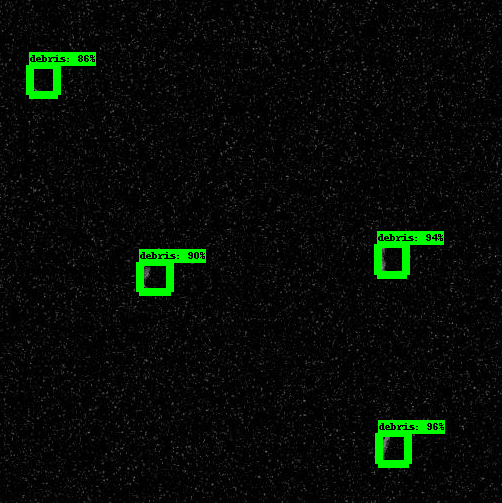

## 1. Download the data

In [ ]:
!pip install aicrowd-cli

In [ ]:
API_KEY = "b46152c118edae059e08ebd1f8ada78f" 
!aicrowd login --api-key $API_KEY

API Key valid
Saved API Key successfully!


In [ ]:
!aicrowd dataset download --challenge debris-detection

sample_submission.csv: 100% 1.98M/1.98M [00:00<00:00, 4.41MB/s]
test.zip: 100% 259M/259M [00:30<00:00, 8.45MB/s]
train.csv: 100% 1.78M/1.78M [00:00<00:00, 3.83MB/s]
train.zip: 100% 1.04G/1.04G [02:19<00:00, 7.43MB/s]
val.csv: 100% 176k/176k [00:00<00:00, 820kB/s]
val.zip: 100% 104M/104M [00:19<00:00, 5.30MB/s]


In [ ]:
!rm -rf data
!mkdir data

!unzip train.zip -d data/train > /dev/null

!unzip val.zip -d data/val > /dev/null

!unzip test.zip -d data/test > /dev/null

!mv train.csv data/train.csv
!mv val.csv data/val.csv

In [ ]:
!rm -rf /content/test.zip
!rm -rf /content/train.zip
!rm -rf /content/val.zip

## 2. Converting Annotations from DataFrame into json files

In [ ]:
import numpy as np 
import pandas as pd

In [ ]:
train = pd.read_csv("/content/data/train.csv")
val = pd.read_csv("/content/data/val.csv")

In [ ]:
train.head()

,ImageID,bboxes
0,0,"[[282, 308, 58, 86], [228, 256, 191, 218], [10..."
1,1,"[[97, 127, 297, 332], [315, 352, 136, 168], [7..."
2,2,"[[45, 76, 244, 269], [154, 182, 457, 484], [20..."
3,3,"[[252, 282, 86, 110], [315, 333, 379, 412], [2..."
4,4,"[[175, 203, 406, 440], [57, 86, 433, 464], [26..."


In [ ]:
print("Train Shape:",train.shape)
print("Val Shape:",val.shape)

Train Shape: (20000, 2)
Val Shape: (2000, 2)


In [ ]:
!mkdir train_annotations
!mkdir val_annotations

In [ ]:
import cv2
import json
from ast import literal_eval
import os
from tqdm import tqdm


def convert_df_json_format(data_dir,df,image_dir):
    for index, row in tqdm(df.iterrows()):
        
        image = cv2.imread(os.path.join(image_dir,f"{row['ImageID']}.jpg"),1)
        width, height,_ = image.shape
        
        data_dict = {
            "file":"",
            "categories":[
                {
                    "class_id":0,
                    "name":"debris"
                }
            ],
            "image_size":[
                {
                    "width":512,
                    "height":512
                }
            ],
            "annotations":[]
        }
        
        data_dict['image_size'][0]['width'] = width
        data_dict['image_size'][0]['height'] = height

        bboxes = literal_eval(row['bboxes'])
        data_dict['file'] = f"{row['ImageID']}.jpg"
        
        
        for n, bbox in enumerate(bboxes):
            ann_dict = {"class_id": 0, 
                        "xmin": bbox[0], 
                        "xmax": bbox[1], 
                        "ymin": bbox[2], 
                        "ymax": bbox[3]}
            data_dict['annotations'].append(ann_dict)

        with open(os.path.join(data_dir,f"{row['ImageID']}.json"),'w') as fp:
            json.dump(data_dict,fp)

In [ ]:
data_dir = "train_annotations"
convert_df_json_format(data_dir,train,image_dir="/content/data/train")

data_dir = "val_annotations"
convert_df_json_format(data_dir,val,image_dir="/content/data/val")

20000it [01:18, 255.02it/s]
2000it [00:07, 251.46it/s]


## 3. Clone the repo & Setup

In [ ]:
# make sure we the required packages
!pip install --user Cython -q
!pip install --user contextlib2 -q
!pip install --user pillow -q
!pip install --user lxml -q
!pip install --user matplotlib -q

In [ ]:
!wget -O protobuf.zip https://github.com/google/protobuf/releases/download/v3.0.0/protoc-3.0.0-linux-x86_64.zip -q
!unzip -o protobuf.zip -d /usr/local bin/protoc
!unzip -o protobuf.zip -d /usr/local include/*
!rm -f protobuf.zip

Archive:  protobuf.zip
  inflating: /usr/local/bin/protoc   
Archive:  protobuf.zip
   creating: /usr/local/include/google/
   creating: /usr/local/include/google/protobuf/
  inflating: /usr/local/include/google/protobuf/struct.proto  
  inflating: /usr/local/include/google/protobuf/type.proto  
  inflating: /usr/local/include/google/protobuf/descriptor.proto  
  inflating: /usr/local/include/google/protobuf/api.proto  
  inflating: /usr/local/include/google/protobuf/empty.proto  
   creating: /usr/local/include/google/protobuf/compiler/
  inflating: /usr/local/include/google/protobuf/compiler/plugin.proto  
  inflating: /usr/local/include/google/protobuf/any.proto  
  inflating: /usr/local/include/google/protobuf/field_mask.proto  
  inflating: /usr/local/include/google/protobuf/wrappers.proto  
  inflating: /usr/local/include/google/protobuf/timestamp.proto  
  inflating: /usr/local/include/google/protobuf/duration.proto  
  inflating: /usr/local/include/google/protobuf/source_contex

In [ ]:
#%cd /kaggle
!rm -fr models
!git clone https://github.com/tensorflow/models.git
!rm -fr models/.git

Cloning into 'models'...
remote: Enumerating objects: 775, done.
remote: Counting objects: 100% (775/775), done.
remote: Compressing objects: 100% (357/357), done.
remote: Total 55523 (delta 465), reused 678 (delta 407), pack-reused 54748
Receiving objects: 100% (55523/55523), 572.00 MiB | 37.79 MiB/s, done.
Resolving deltas: 100% (38124/38124), done.


In [ ]:
%%bash
cd models/research
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1643278 sha256=cfb1af4a13905dfa57dce64f4ee1eb8c25003deb6acdd839613d7b40825df7e1
  Stored in directory: /tmp/pip-ephem-wheel-cache-l4f5jt79/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.2-cp37-none-any.whl size=44011 sha256=69af4df7348b38c1edb470afef4f882d0c284b1fc80d5d66691326f44d6e135a
  Stored in directory: /root/.cache/pip/wheels/ee/ee/18/c466221ca6900e3efce2f4ea9c329288808679aecdcb2838d3
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=5ab9ea691c723f6bf151c546bf4046648b0b57d0d566c9bbcde5796c0abc86ac
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for dill: filename=dill-0.3.1.1-cp37-none-any.whl size=78532 sha256=df6b800a9b3bff29bb981b6c22c5511f78f4222f44f988b8718a

ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: apache-beam 2.28.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.2 which is incompatible.


In [ ]:
import os

os.environ['AUTOGRAPH_VERBOSITY'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONPATH']=os.environ['PYTHONPATH']+':/content/models/research/slim:/content/models/research'
os.environ['PYTHONPATH']

'/env/python:/content/models/research/slim:/content/models/research'

In [ ]:
!pip install tf_slim

### Testing the Installation & setup

In [ ]:
%cd /content/models/research/

/content/models/research


In [ ]:
!pwd
!python object_detection/builders/model_builder_tf2_test.py

/content/models/research
Running tests under Python 3.7.10: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_model): 5.92s
I0407 15:40:05.671451 140114164356992 test_util.py:2076] time(__main__.ModelBuilderTF2Test.test_create_center_net_model): 5.92s
[       OK ] ModelBuilderTF2Test.test_create_center_net_model
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model_from_keypoints
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_model_from_keypoints): 0.32s
I0407 15:40:05.995669 140114164356992 test_util.py:2076] time(__main__.ModelBuilderTF2Test.test_create_center_net_model_from_keypoints): 0.32s
[       OK ] ModelBuilderTF2Test.test_create_center_net_model_from_keypoints
[ RUN      ] ModelBuilderTF2Test.test_create_experimental_model
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_experimental_model): 0.0s
I0407 15:40:05.996314 14011416435

### This is to check if tensorflow recognized the GPU or not

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5426627529027687106, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17164358435409490225
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

## 4. Preparation of Data [TfRecords]

In [ ]:
%cd /content

/content


In [ ]:
!mkdir train

In [ ]:
%%writefile train/label_map.pbtxt

item {
    id: 1
    name:'debris'
}

Writing train/label_map.pbtxt


In [ ]:
%cd /content/models/research/

/content/models/research


In [ ]:
from object_detection.utils import label_map_util

label_map_util.get_label_map_dict('../../train/label_map.pbtxt')

{'debris': 1}

In [ ]:
import contextlib2
import logging
import json
import io
import os

import hashlib
import numpy as np
import PIL.Image

import tensorflow.compat.v1 as tf
from object_detection.dataset_tools import tf_record_creation_util
from object_detection.utils import dataset_util
from object_detection.utils import label_map_util

class create_tf_records_data:
    def __init__(self,
                 anno_data_dir,
                 image_data_dir,
                 label_txt_path,
                 output_path):

        self.num_shards = 10
        
        self.anno_data_dir = anno_data_dir #"/content"
        self.image_data_dir = image_data_dir
        self.label_txt_path = label_txt_path #"/content/train/label_map.pbtxt"
        self.output_path = output_path #"/content/train/"
        

        self.label_map_dict = label_map_util.get_label_map_dict(self.label_txt_path)

        self.train_output_path = os.path.join(self.output_path, 'debris_train.record')
        self.val_output_path = os.path.join(self.output_path, 'debris_val.record')


    def create_tf_record(self, output_filename, examples,annotations_dir,image_dir):
        """Creates a TFRecord file from examples.

        Args:
            output_filename: Path to where output file is saved.
            num_shards: Number of shards for output file.
            label_map_dict: The label map dictionary.
            annotations_dir: Directory where annotation files are stored.
            image_dir: Directory where image files are stored.
            examples: Examples to parse and save to tf record.
        """
        with contextlib2.ExitStack() as tf_record_close_stack:
            output_tfrecords = tf_record_creation_util.open_sharded_output_tfrecords(
                tf_record_close_stack, output_filename, self.num_shards)
            for idx, example in enumerate(examples):
                if idx % 100 == 0:
                    logging.info('On image %d of %d', idx, len(examples))
                json_path = os.path.join(annotations_dir, example)

                if not os.path.exists(json_path):
                    logging.warning('Could not find %s, ignoring example.', json_path)
                    continue

                with open(json_path) as f:
                    data = json.load(f)
                
                try:
                    tf_example = self.dict_to_tf_example(data,image_dir)
                    if tf_example:
                        shard_idx = idx % self.num_shards
                        output_tfrecords[shard_idx].write(tf_example.SerializeToString())
                except ValueError:
                    logging.warning('Invalid example: %s, ignoring.', json_path)


    def dict_to_tf_example(self,data,image_dir):

        img_path = os.path.join(image_dir, data['file'])
        with tf.gfile.GFile(img_path, 'rb') as fid:
            encoded_jpg = fid.read()
        encoded_jpg_io = io.BytesIO(encoded_jpg)
        image = PIL.Image.open(encoded_jpg_io)
        key = hashlib.sha256(encoded_jpg).hexdigest()

        width = int(data['image_size'][0]['width'])
        height = int(data['image_size'][0]['height'])
        
        xmins = []
        ymins = []
        xmaxs = []
        ymaxs = []
        classes = []
        classes_text = []

        if data['annotations']:
            for obj in data['annotations']:
                xmin = float(obj['xmin'])
                xmax = float(obj['xmax'])
                ymin = float(obj['ymin'])
                ymax = float(obj['ymax'])
                

                xmins.append(xmin / width)
                ymins.append(ymin / height)
                xmaxs.append(xmax / width)
                ymaxs.append(ymax / height)
        
                class_name = data['categories'][obj['class_id']]['name']
                class_name = class_name.replace(" ","_")
                classes_text.append(class_name.encode('utf8'))
                classes.append(self.label_map_dict[class_name])
        

            feature_dict = {
                'image/height': dataset_util.int64_feature(height),
                'image/width': dataset_util.int64_feature(width),
                'image/filename': dataset_util.bytes_feature(
                                    data['file'].encode('utf8')),
                'image/source_id': dataset_util.bytes_feature(
                                    data['file'].encode('utf8')),
                'image/key/sha256': dataset_util.bytes_feature(key.encode('utf8')),
                'image/encoded': dataset_util.bytes_feature(encoded_jpg),
                'image/format': dataset_util.bytes_feature('png'.encode('utf8')),
                'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
                'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
                'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
                'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
                'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
                'image/object/class/label': dataset_util.int64_list_feature(classes),
                        }
            
            example = tf.train.Example(features=tf.train.Features(feature=feature_dict))
            return example

    def run(self):
        
        train_examples = os.listdir(os.path.join(self.anno_data_dir,"train_annotations"))
        
        annotations_dir = os.path.join(self.anno_data_dir,"train_annotations")
        image_dir = os.path.join(self.image_data_dir,"train")

        self.create_tf_record(self.train_output_path,train_examples,annotations_dir,image_dir)
        print("Training Data Converted into tf Format!")

        val_examples = os.listdir(os.path.join(self.anno_data_dir,"val_annotations"))
        annotations_dir = os.path.join(self.anno_data_dir,"val_annotations")
        image_dir = os.path.join(self.image_data_dir,"val")

        self.create_tf_record(self.val_output_path,val_examples,annotations_dir,image_dir)
        print("Validation Data Converted into tf Format!")

In [ ]:
anno_data_dir = "/content"
image_data_dir = "../../data"
output_dir= "../../train/" 
label_txt_path = "../../train/label_map.pbtxt"

records = create_tf_records_data(anno_data_dir,
                                 image_data_dir,
                                 label_txt_path,
                                 output_dir)
records.run()

Training Data Converted into tf Format!
Validation Data Converted into tf Format!


In [ ]:
!ls ../../train

debris_train.record-00000-of-00010  debris_val.record-00001-of-00010
debris_train.record-00001-of-00010  debris_val.record-00002-of-00010
debris_train.record-00002-of-00010  debris_val.record-00003-of-00010
debris_train.record-00003-of-00010  debris_val.record-00004-of-00010
debris_train.record-00004-of-00010  debris_val.record-00005-of-00010
debris_train.record-00005-of-00010  debris_val.record-00006-of-00010
debris_train.record-00006-of-00010  debris_val.record-00007-of-00010
debris_train.record-00007-of-00010  debris_val.record-00008-of-00010
debris_train.record-00008-of-00010  debris_val.record-00009-of-00010
debris_train.record-00009-of-00010  label_map.pbtxt
debris_val.record-00000-of-00010


## 5. Download the pretrained Model

In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
!tar -xvf efficientdet_d0_coco17_tpu-32.tar.gz
!rm efficientdet_d0_coco17_tpu-32.tar.gz

--2021-04-07 15:44:56--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.5.240, 2607:f8b0:4004:804::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.5.240|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30736482 (29M) [application/x-tar]
Saving to: ‘efficientdet_d0_coco17_tpu-32.tar.gz’

efficientdet_d0_coc 100%[===================>]  29.31M  --.-KB/s    in 0.1s    

2021-04-07 15:44:56 (249 MB/s) - ‘efficientdet_d0_coco17_tpu-32.tar.gz’ saved [30736482/30736482]

efficientdet_d0_coco17_tpu-32/
efficientdet_d0_coco17_tpu-32/checkpoint/
efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0.data-00000-of-00001
efficientdet_d0_coco17_tpu-32/checkpoint/checkpoint
efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0.index
efficientdet_d0_coco17_tpu-32/pipeline.config
efficientdet_d0_coco17_tpu-32/saved_model/
efficientdet_d

## 6. Configure the Pipeline for training & evaluation

In [ ]:
%%writefile ../../train/pipeline.config

model {
  ssd {
    num_classes: 1
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 512
        max_dimension: 512
        pad_to_max_dimension: true
      }
    }
    feature_extractor {
      type: "ssd_efficientnet-b0_bifpn_keras"
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 3.9999998989515007e-05
          }
        }
        initializer {
          truncated_normal_initializer {
            mean: 0.0
            stddev: 0.029999999329447746
          }
        }
        activation: SWISH
        batch_norm {
          decay: 0.9900000095367432
          scale: true
          epsilon: 0.0010000000474974513
        }
        force_use_bias: true
      }
      bifpn {
        min_level: 3
        max_level: 7
        num_iterations: 3
        num_filters: 64
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 1.0
        x_scale: 1.0
        height_scale: 1.0
        width_scale: 1.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    box_predictor {
      weight_shared_convolutional_box_predictor {
        conv_hyperparams {
          regularizer {
            l2_regularizer {
              weight: 3.9999998989515007e-05
            }
          }
          initializer {
            random_normal_initializer {
              mean: 0.0
              stddev: 0.009999999776482582
            }
          }
          activation: SWISH
          batch_norm {
            decay: 0.9900000095367432
            scale: true
            epsilon: 0.0010000000474974513
          }
          force_use_bias: true
        }
        depth: 64
        num_layers_before_predictor: 3
        kernel_size: 3
        class_prediction_bias_init: -4.599999904632568
        use_depthwise: true
      }
    }
    anchor_generator {
      multiscale_anchor_generator {
        min_level: 3
        max_level: 7
        anchor_scale: 4.0
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        scales_per_octave: 3
      }
    }
    post_processing {
      batch_non_max_suppression {
        score_threshold: 9.99999993922529e-09
        iou_threshold: 0.5
        max_detections_per_class: 100
        max_total_detections: 100
      }
      score_converter: SIGMOID
    }
    normalize_loss_by_num_matches: true
    loss {
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      classification_loss {
        weighted_sigmoid_focal {
          gamma: 1.5
          alpha: 0.25
        }
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    encode_background_as_zeros: true
    normalize_loc_loss_by_codesize: true
    inplace_batchnorm_update: true
    freeze_batchnorm: false
    add_background_class: false
  }
}
train_config {
  batch_size: 16
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    random_scale_crop_and_pad_to_square {
      output_size: 512
      scale_min: 0.10000000149011612
      scale_max: 2.0
    }
  }
  sync_replicas: true
  optimizer {
    momentum_optimizer {
      learning_rate {
        cosine_decay_learning_rate {
          learning_rate_base: 0.07999999821186066
          total_steps: 300000
          warmup_learning_rate: 0.0010000000474974513
          warmup_steps: 2500
        }
      }
      momentum_optimizer_value: 0.8999999761581421
    }
    use_moving_average: false
  }
  fine_tune_checkpoint: "models/research/efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0"
  num_steps: 4000
  startup_delay_steps: 0.0
  replicas_to_aggregate: 8
  max_number_of_boxes: 100
  unpad_groundtruth_tensors: false
  fine_tune_checkpoint_type: "detection"
  use_bfloat16: false
  fine_tune_checkpoint_version: V2
}
train_input_reader: {
  label_map_path: "train/label_map.pbtxt"
  tf_record_input_reader {
    input_path: "train/debris_train.record-?????-of-00010"
  }
}

eval_config: {
  metrics_set: "coco_detection_metrics"
  use_moving_averages: false
  batch_size: 1
  num_examples: 998
  num_visualizations: 10
}

eval_input_reader: {
  label_map_path: "train/label_map.pbtxt"
  shuffle: false
  num_epochs: 1
  tf_record_input_reader {
    input_path: "train/debris_val.record-?????-of-00010"
  }
}

Writing ../../train/pipeline.config


## 7. Training the model

In [ ]:
!mkdir efficientdet_d0_coco17_tpu-32/model_directory

In [ ]:
%cd /content

/content


In [ ]:
#train
PIPELINE_CONFIG_PATH='train/pipeline.config'
MODEL_DIR= "models/research/efficientdet_d0_coco17_tpu-32/model_directory/"
!python models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path=$PIPELINE_CONFIG_PATH \
    --model_dir=$MODEL_DIR \
    --alsologtostderr \
    --checkpoint_every_n=600

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0407 15:45:37.208154 139887251376000 mirrored_strategy.py:350] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: None
I0407 15:45:37.212651 139887251376000 config_util.py:552] Maybe overwriting train_steps: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0407 15:45:37.212809 139887251376000 config_util.py:552] Maybe overwriting use_bfloat16: False
I0407 15:45:37.225318 139887251376000 ssd_efficientnet_bifpn_feature_extractor.py:143] EfficientDet EfficientNet backbone version: efficientnet-b0
I0407 15:45:37.225425 139887251376000 ssd_efficientnet_bifpn_feature_extractor.py:144] EfficientDet BiFPN num filters: 64
I0407 15:45:37.225513 139887251376000 ssd_efficientnet_bifpn_feature_extractor.py:146] EfficientDet BiFPN num iterations: 3
I0407 15:45:37.232271 139887251376000 efficientnet_model.py

## 8. Evaluating of Model

In [ ]:
#Eval

checkpoint_path = 'models/research/efficientdet_d0_coco17_tpu-32/model_directory/'

PIPELINE_CONFIG_PATH='train/pipeline.config'
MODEL_DIR= "models/research/efficientdet_d0_coco17_tpu-32/model_directory/"

!python3 models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path=$PIPELINE_CONFIG_PATH \
    --checkpoint_dir=$checkpoint_path \
    --model_dir=$MODEL_DIR \
    --eval_timeout=60 \
    --alsologtostderr

W0407 17:04:18.661984 140706411427712 model_lib_v2.py:1063] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0407 17:04:18.662194 140706411427712 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0407 17:04:18.662282 140706411427712 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0407 17:04:18.662377 140706411427712 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0407 17:04:18.662490 140706411427712 model_lib_v2.py:1084] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
I0407 17:04:19.228398 140706411427712 ssd_efficientnet_bifpn_feature_extractor.py:143] EfficientDet EfficientNet backbone version: efficientnet-b0
I0407 17:04:19.228572 140706411427712 ssd_efficientnet_b

## 9. Exporting the model

In [ ]:
!python models/research/object_detection/exporter_main_v2.py \
       --input_type=image_tensor \
       --pipeline_config_path=train/pipeline.config \
       --trained_checkpoint_dir=models/research/efficientdet_d0_coco17_tpu-32/model_directory/ \
       --output_directory=models/research/efficientdet_d0_coco17_tpu-32/exported_graphs


I0407 17:10:33.314326 140099260376960 ssd_efficientnet_bifpn_feature_extractor.py:143] EfficientDet EfficientNet backbone version: efficientnet-b0
I0407 17:10:33.314517 140099260376960 ssd_efficientnet_bifpn_feature_extractor.py:144] EfficientDet BiFPN num filters: 64
I0407 17:10:33.314605 140099260376960 ssd_efficientnet_bifpn_feature_extractor.py:146] EfficientDet BiFPN num iterations: 3
I0407 17:10:33.320029 140099260376960 efficientnet_model.py:147] round_filter input=32 output=32
I0407 17:10:33.338742 140099260376960 efficientnet_model.py:147] round_filter input=32 output=32
I0407 17:10:33.338893 140099260376960 efficientnet_model.py:147] round_filter input=16 output=16
I0407 17:10:33.394485 140099260376960 efficientnet_model.py:147] round_filter input=16 output=16
I0407 17:10:33.394633 140099260376960 efficientnet_model.py:147] round_filter input=24 output=24
I0407 17:10:33.533637 140099260376960 efficientnet_model.py:147] round_filter input=24 output=24
I0407 17:10:33.533807 140

## 10. Inference on Test Data

In [ ]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
    raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')


# This is needed to display the images.
%matplotlib inline

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [ ]:
%cd /content/models/research/

/content/models/research


In [ ]:
PATH_TO_LABELS = '../../train/label_map.pbtxt'

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
category_index

{1: {'id': 1, 'name': 'debris'}}

In [ ]:
model = tf.saved_model.load(str("efficientdet_d0_coco17_tpu-32/exported_graphs/saved_model"))

In [ ]:
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]
    
    # Run inference
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)

#    print(output_dict['detection_classes'][0].numpy())

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections
  
    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

    return output_dict
    
def show_inference(model, image_path):
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = np.array(Image.open(image_path))
    # Actual detection.
    output_dict = run_inference_for_single_image(model, image_np)

    return output_dict

In [ ]:
from tqdm import tqdm
import pandas as pd
import cv2

data_path  = "../../data"

test_imgs_paths = os.listdir(os.path.join(data_path, "test"))

predictions = {"ImageID":[], "bboxes":[]}

for test_img_path in tqdm(test_imgs_paths):
    
    img = cv2.imread(os.path.join(data_path, "test", test_img_path))
    h, w, _ = img.shape
  
    output_dict = show_inference(model,os.path.join(data_path, "test", test_img_path))
    
    res = [idx for idx, val in enumerate(output_dict['detection_scores']) if val >=0.5]
    
    bbox_result = [list(output_dict['detection_boxes'][i]) for i in res]
    score_result = [output_dict['detection_scores'][i] for i in res]
    
    bbox_res = []
    # 0 1 2 3
    #[ymin, xmin, ymax, xmax]
    for n, bbox in enumerate(bbox_result):
        box = [bbox[1]*512,bbox[3]*512,bbox[0]*512,bbox[2]*512]
        box.append(score_result[n])
        bbox_res.append(box)
        
    image_id = test_img_path.split('.')[0]

    predictions['ImageID'].append(image_id)
    predictions['bboxes'].append(bbox_res)

100%|██████████| 5000/5000 [03:23<00:00, 24.52it/s]


In [ ]:
submission = pd.DataFrame(predictions)
submission.head()

,ImageID,bboxes
0,4740,"[[330.9046630859375, 360.47747802734375, 298.8..."
1,2558,"[[26.15998077392578, 54.58891296386719, 239.51..."
2,416,"[[185.36703491210938, 209.46847534179688, 366...."
3,1714,"[[196.9901580810547, 222.3970184326172, 379.12..."
4,263,"[[436.9689025878906, 462.4322814941406, 43.295..."


In [ ]:
submission.to_csv("submission.csv", index=False)

In [ ]:
!aicrowd submission create -c debris-detection -f submission.csv

submission.csv ━━━━━━━━━━━━━━━━━━━━━━━━ 100.0% • 1.5/1.5 MB • 2.0 MB/s • 0:00:00
                                                 ╭─────────────────────────╮                                                  
                                                 │ Successfully submitted! │                                                  
                                                 ╰─────────────────────────╯                                                  
                                                       Important links                                                        
┌──────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/ai-blitz-7/problems/debris-detection/submissions/128637              │
│                  │                                                                                                         │
│  All submissions │ https://w